<div id="top">
<!-- <div style="background-image: url(https://www.emtmadrid.es/getattachment/da3be644-cb9d-44db-8011-e3f40f1c5c34); opacity: 0.2"/> -->
<hr>
<img src="https://www.gmv.com/sites/default/files/content/image/2021/11/03/115/gmv_rgbredblack.png" alt="GMV Logo" style="width: 200px">
<img src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/CEI/LOGOTIPO%20leyenda%20color%20JPG%20p.png" alt="UPM Logo" style="float: right; width: 200px">
<h4>INESDATA-MOV</h4>
<h1>QA: EMT dataset 🚌</h1>
<h5 style="text-align: right">GMV-SES BDA<br><b>Sprint 3</b></h5>
</div>

Este cuaderno analiza la calidad del dataset proveniente de la fuente de datos de la Empresa Municipal de Transportes de Madrid ([EMT](https://www.emtmadrid.es/Home)). La calidad del mismo se validará teniendo en cuenta los siguientes aspectos:
* Análisis de las variables
* Tipos de datos
* Valores perdidos
* Correlaciones entre variables

La **calidad del dato** se refiere a la medida en que los datos son adecuados para su uso, por lo que es esencial para garantizar la confiabilidad y utilidad de los datos en diversas aplicaciones y contextos. Así, en este notebook se evaluarán también las cinco dimensiones de la calidad del dato:
1. **Exactitud**: Los datos exactos son libres de errores y representan con precisión la realidad que están destinados a describir. Esto implica que los datos deben ser correctos y confiables para su uso en análisis y toma de decisiones.
2. **Completitud**: Los datos completos contienen toda la información necesaria para el análisis y no tienen valores faltantes o nulos que puedan afectar la interpretación o validez de los resultados.
3. **Consistencia**: Los datos consistentes mantienen el mismo formato, estructura y significado en todas las instancias, lo que facilita su comparación y análisis sin ambigüedad.
4. **Validez**: Medida en que los datos son precisos y representan con exactitud la realidad que están destinados a describir. 
5. **Unicidad**: Ausencia de duplicados o registros repetidos en un conjunto de datos. Los datos son únicos cuando cada registro o entidad en el conjunto de datos es único y no hay duplicados presentes.

> Este dataset ha sido creado ejecutando el comando `create` del paquete de Python [`inesdata_mov_datasets`](https://github.com/oeg-upm/inesdata-mov-data-generation).
> Para poder ejecutar este comando es necesario haber ejecutado antes el comando `extract`, que realiza la extracción de datos de la API de la EMT y los almacena en Minio. El comando `create` se encargaría de descargar dichos datos y unirlos todos en un único dataset.

In [47]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("deep")
import warnings
warnings.filterwarnings('ignore')

In [48]:
ROOT_PATH = os.path.dirname(os.path.abspath(os.getcwd()))
DATA_PATH = os.path.join(ROOT_PATH, 'data', 'processed')
EMT_DATA_PATH = os.path.join(DATA_PATH, 'emt')
EMT_DATA_PATH

'/home/code/inesdata-mov/data-generation/data/processed/emt'

Cada fila de este dataset representa el tiempo de espera de un autobus desde una parada A, a una determinada parada B de una cierta línea L, en una fecha y hora concretos.

Sobre las cols:
* `date`: Fecha de la petición a la [API](https://apidocs.emtmadrid.es/#api-Block_3_TRANSPORT_BUSEMTMAD-arrives)
* `datetime`: Fecha y hora de la petición a la [API](https://apidocs.emtmadrid.es/#api-Block_3_TRANSPORT_BUSEMTMAD-arrives)
* `line`: Línea de bus
* `stop`: Parada de bus
* `bus`: Número identificador del bus
* `positionBusLon`: Longitud de las coordenadas del bus
* `positionBusLat`: Latitud de las coordenadas del bus
* `positionTypeBus`: Tipo de la posición del bus (_0_: , _2_: , _5_: )
* `DistanceBus`: Distancia del bus a la parada (en metros)
* `destination`: Destino del itinerario
* `deviation`: Desviación en el cálculo del ETA
* `StartTime`: Hora de inicio de la línea
* `StopTime`: Hora de fin de la línea
* `MinimunFrequency`: Frecuencia mínima de la línea
* `MaximumFrequency`: Frecuencia máxima de la línea
* `isHead`: Variable booleana para indicar si la parada es la cabecera de la línea
* `dayType`: Tipo de día (_LA_: laboral, _FE_: festivo, _SA_: sábado)
* `strike`: Variable para indicar si ese día hay huelga (_S_) o no (_N_)
* **`estimateArrive`**: Tiempo estimado de espera del bus (en segundos)

In [49]:
for w in os.walk(EMT_DATA_PATH):
    print(w)

('/home/code/inesdata-mov/data-generation/data/processed/emt', ['2024'], [])
('/home/code/inesdata-mov/data-generation/data/processed/emt/2024', ['03'], [])
('/home/code/inesdata-mov/data-generation/data/processed/emt/2024/03', ['12', '02', '11'], [])
('/home/code/inesdata-mov/data-generation/data/processed/emt/2024/03/12', [], ['emt_20240312.csv'])
('/home/code/inesdata-mov/data-generation/data/processed/emt/2024/03/02', [], ['emt_20240302.csv'])
('/home/code/inesdata-mov/data-generation/data/processed/emt/2024/03/11', [], ['emt_20240311.csv'])


> **NOTA**: Vamos a analizar la calidad del dataset generado para el día 12 de marzo, que es el más completo.

In [50]:
df = pd.read_csv(os.path.join(EMT_DATA_PATH, '2024', '03', '12', 'emt_20240312.csv'), parse_dates=['date', 'datetime'])
df

,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
0,2024-03-12,2024-03-12 07:58:57.264347,517,27,54,-3.690321,40.424226,0,1617,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,394
1,2024-03-12,2024-03-12 07:58:57.264347,537,27,54,-3.689487,40.437052,0,564,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,124
2,2024-03-12,2024-03-12 07:58:57.264347,2556,150,54,-3.691950,40.420574,0,2461,VIRGEN CORTIJO,0,NaN,NaN,NaN,NaN,False,NaN,NaN,605
3,2024-03-12,2024-03-12 07:58:57.264347,2558,150,54,-3.690322,40.438481,0,61,VIRGEN CORTIJO,0,NaN,NaN,NaN,NaN,False,NaN,NaN,37
4,2024-03-12,2024-03-12 07:58:57.264347,5572,14,54,-3.689977,40.425010,0,1900,PIO XII,0,NaN,NaN,NaN,NaN,False,NaN,NaN,495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144870,2024-03-12,2024-03-12 09:56:36.142168,4702,133,1615,-3.706104,40.492207,0,3080,CALLAO,0,NaN,NaN,NaN,NaN,False,NaN,NaN,803
144871,2024-03-12,2024-03-12 09:56:36.142168,5554,124,1615,-3.701336,40.487233,0,784,LACOMA,0,NaN,NaN,NaN,NaN,False,NaN,NaN,198
144872,2024-03-12,2024-03-12 09:56:36.142168,5555,124,1615,-3.685187,40.488671,0,2965,LACOMA,0,NaN,NaN,NaN,NaN,False,NaN,NaN,689
144873,2024-03-12,2024-03-12 09:56:36.142168,5566,67,1615,-3.700158,40.484840,0,1096,BARRIO PEÑAGRANDE,0,06:00,23:45,9.0,30.0,False,LA,N,248


En este dataset están todas las líneas, tenemos que filtrar por las de Plaza Castilla.

In [51]:
lines = ['27', '42', '49', '67', '70', '107', '129', '134', '135', '173', '174', '175', '176', '177', '178']

df = df[df['line'].isin(lines)]
df

,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
0,2024-03-12,2024-03-12 07:58:57.264347,517,27,54,-3.690321,40.424226,0,1617,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,394
1,2024-03-12,2024-03-12 07:58:57.264347,537,27,54,-3.689487,40.437052,0,564,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,124
12,2024-03-12,2024-03-12 07:58:57.370357,2469,134,1022,-3.708424,40.498820,0,1914,MONTECARMELO,0,06:25,23:45,9.0,26.0,False,LA,N,461
13,2024-03-12,2024-03-12 07:58:57.370357,2472,134,1022,-3.704560,40.481786,0,5905,MONTECARMELO,0,06:25,23:45,9.0,26.0,False,LA,N,1229
14,2024-03-12,2024-03-12 07:58:57.370357,2502,178,1022,-3.700528,40.496409,0,3142,MONTECARMELO,0,06:00,23:45,6.0,22.0,False,LA,N,763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144864,2024-03-12,2024-03-12 09:56:36.139745,4736,49,5329,-3.711952,40.471423,0,1673,PITIS,0,06:10,23:45,4.0,15.0,False,LA,N,548
144865,2024-03-12,2024-03-12 09:56:36.140625,9125,177,5802,-3.695560,40.470752,0,2387,MARQUES DE VIANA,0,06:20,23:30,9.0,24.0,False,LA,N,1600
144866,2024-03-12,2024-03-12 09:56:36.140625,9130,177,5802,-3.688212,40.467565,0,1365,MARQUES DE VIANA,0,06:20,23:30,9.0,24.0,False,LA,N,700
144873,2024-03-12,2024-03-12 09:56:36.142168,5566,67,1615,-3.700158,40.484840,0,1096,BARRIO PEÑAGRANDE,0,06:00,23:45,9.0,30.0,False,LA,N,248


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76386 entries, 0 to 144874
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              76386 non-null  datetime64[ns]
 1   datetime          76386 non-null  datetime64[ns]
 2   bus               76386 non-null  int64         
 3   line              76386 non-null  object        
 4   stop              76386 non-null  int64         
 5   positionBusLon    76386 non-null  float64       
 6   positionBusLat    76386 non-null  float64       
 7   positionTypeBus   76386 non-null  int64         
 8   DistanceBus       76386 non-null  int64         
 9   destination       76386 non-null  object        
 10  deviation         76386 non-null  int64         
 11  StartTime         76386 non-null  object        
 12  StopTime          76386 non-null  object        
 13  MinimunFrequency  76386 non-null  float64       
 14  MaximumFrequency  76386 no

In [53]:
df.columns

Index(['date', 'datetime', 'bus', 'line', 'stop', 'positionBusLon',
       'positionBusLat', 'positionTypeBus', 'DistanceBus', 'destination',
       'deviation', 'StartTime', 'StopTime', 'MinimunFrequency',
       'MaximumFrequency', 'isHead', 'dayType', 'strike', 'estimateArrive'],
      dtype='object')

In [54]:
df['stop'].nunique()

283

In [55]:
df['line'].nunique()

15

In [56]:
df['bus'].nunique()

162

La variable `positionTypeBus` parece no dar mucha información, y en la documentación de la [API](https://apidocs.emtmadrid.es/#api-Block_3_TRANSPORT_BUSEMTMAD-arrives) no aparece el significado de sus valores. Por tanto, decidimos eliminarla.

In [57]:
print(df['positionTypeBus'].value_counts())
df.drop(columns='positionTypeBus', inplace=True)

positionTypeBus
0    76296
5       86
2        4
Name: count, dtype: int64


## Summary del dataset

In [58]:
df.describe()

,date,datetime,bus,stop,positionBusLon,positionBusLat,DistanceBus,deviation,MinimunFrequency,MaximumFrequency,estimateArrive
count,76386,76386,76386.000000,76386.000000,76386.000000,76386.000000,76386.000000,76386.000000,76386.000000,76386.000000,76386.000000
mean,2024-03-12 00:00:00,2024-03-12 08:57:53.148961024,3414.282879,2886.254287,-3.684767,40.457489,1970.697733,5.042861,7.185283,21.386393,547.547849
min,2024-03-12 00:00:00,2024-03-12 07:58:57.264347,506.000000,29.000000,-3.734004,0.000000,-1850.000000,0.000000,3.000000,12.000000,0.000000
25%,2024-03-12 00:00:00,2024-03-12 08:27:03.738934272,2135.000000,1360.000000,-3.694660,40.467276,708.000000,0.000000,4.000000,17.000000,213.000000
50%,2024-03-12 00:00:00,2024-03-12 08:58:45.893911040,2474.000000,1843.000000,-3.688456,40.471749,1563.000000,0.000000,7.000000,22.000000,450.000000
75%,2024-03-12 00:00:00,2024-03-12 09:27:59.176144896,4859.000000,4266.000000,-3.678861,40.482336,2870.000000,0.000000,9.000000,24.000000,766.000000
max,2024-03-12 00:00:00,2024-03-12 09:56:36.142168,9130.000000,51023.000000,0.000000,40.516560,15920.000000,8374.000000,12.000000,30.000000,999999.000000
std,NaN,NaN,2434.705740,4143.218879,0.071930,0.761012,1650.442405,205.436224,2.640639,4.817027,5128.558343


In [59]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#total'] = df.shape[0]
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    summ['#duplicates'] = summ['#total'] - summ['#unique']
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    return summ

summary(df).style.background_gradient(cmap='Blues')

,data type,#total,#missing,%missing,#unique,#duplicates,min,max
date,datetime64[ns],76386,0,0.000000,1,76385,2024-03-12 00:00:00,2024-03-12 00:00:00
datetime,datetime64[ns],76386,0,0.000000,30668,45718,2024-03-12 07:58:57.264347,2024-03-12 09:56:36.142168
bus,int64,76386,0,0.000000,162,76224,506.000000,9130.000000
line,object,76386,0,0.000000,15,76371,nan,nan
stop,int64,76386,0,0.000000,283,76103,29.000000,51023.000000
positionBusLon,float64,76386,0,0.000000,9115,67271,-3.734004,0.000000
positionBusLat,float64,76386,0,0.000000,9115,67271,0.000000,40.516560
DistanceBus,int64,76386,0,0.000000,7280,69106,-1850.000000,15920.000000
destination,object,76386,0,0.000000,14,76372,nan,nan
deviation,int64,76386,0,0.000000,2,76384,0.000000,8374.000000


## Missings

In [60]:
df.isna().sum()

date                0
datetime            0
bus                 0
line                0
stop                0
positionBusLon      0
positionBusLat      0
DistanceBus         0
destination         0
deviation           0
StartTime           0
StopTime            0
MinimunFrequency    0
MaximumFrequency    0
isHead              0
dayType             0
strike              0
estimateArrive      0
dtype: int64

## Dtypes

In [61]:
num_cols = list(df.select_dtypes(include=np.number).columns)
cat_cols = list(df.select_dtypes(include=['object', bool]).columns)
date_cols = list(df.select_dtypes(exclude=[np.number, 'object', bool]).columns)

print(f"Numeric cols: {num_cols}")
print(f"Categoric cols: {cat_cols}")
print(f"Date cols: {date_cols}")

Numeric cols: ['bus', 'stop', 'positionBusLon', 'positionBusLat', 'DistanceBus', 'deviation', 'MinimunFrequency', 'MaximumFrequency', 'estimateArrive']
Categoric cols: ['line', 'destination', 'StartTime', 'StopTime', 'isHead', 'dayType', 'strike']
Date cols: ['date', 'datetime']


In [62]:
# Convert line, stop and bus to categoric
df['stop'] = df['stop'].astype('category')
df['line'] = df['line'].astype('category')
df['bus'] = df['bus'].astype('category')

In [63]:
# Update dytpes cols
num_cols = list(df.select_dtypes(include=np.number).columns)
cat_cols = list(df.select_dtypes(include=['object', bool, 'category']).columns)
date_cols = list(df.select_dtypes(exclude=[np.number, 'object', bool, 'category']).columns)

print(f"Numeric cols: {num_cols}")
print(f"Categoric cols: {cat_cols}")
print(f"Date cols: {date_cols}")

Numeric cols: ['positionBusLon', 'positionBusLat', 'DistanceBus', 'deviation', 'MinimunFrequency', 'MaximumFrequency', 'estimateArrive']
Categoric cols: ['bus', 'line', 'stop', 'destination', 'StartTime', 'StopTime', 'isHead', 'dayType', 'strike']
Date cols: ['date', 'datetime']


## Correlaciones

In [64]:
df[num_cols].corr().style.background_gradient()

,positionBusLon,positionBusLat,DistanceBus,deviation,MinimunFrequency,MaximumFrequency,estimateArrive
positionBusLon,1.000000,-0.963399,0.008857,-0.012476,0.044629,-0.004906,0.000021
positionBusLat,-0.963399,1.000000,0.009170,0.001146,-0.023265,0.002779,0.000813
DistanceBus,0.008857,0.009170,1.000000,-0.018392,0.320931,0.283734,0.101760
deviation,-0.012476,0.001146,-0.018392,1.000000,-0.029610,-0.032545,-0.001156
MinimunFrequency,0.044629,-0.023265,0.320931,-0.029610,1.000000,0.783214,0.025969
MaximumFrequency,-0.004906,0.002779,0.283734,-0.032545,0.783214,1.000000,0.020753
estimateArrive,0.000021,0.000813,0.101760,-0.001156,0.025969,0.020753,1.000000


## Distribuciones

In [65]:
var_name = 'DistanceBus'

In [66]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df[var_name].describe())


Estadísticas descriptivas:
count    76386.000000
mean      1970.697733
std       1650.442405
min      -1850.000000
25%        708.000000
50%       1563.000000
75%       2870.000000
max      15920.000000
Name: DistanceBus, dtype: float64


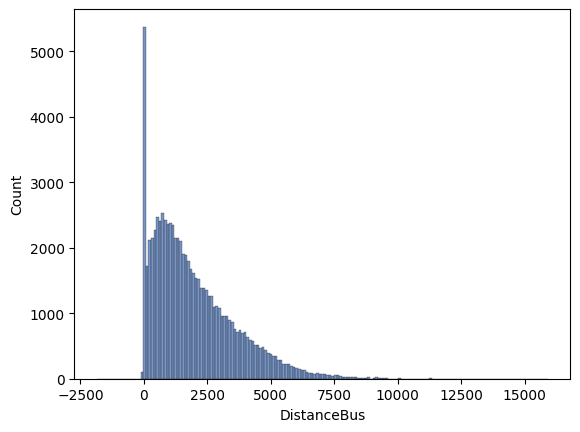

In [67]:
sns.histplot(df[var_name]);

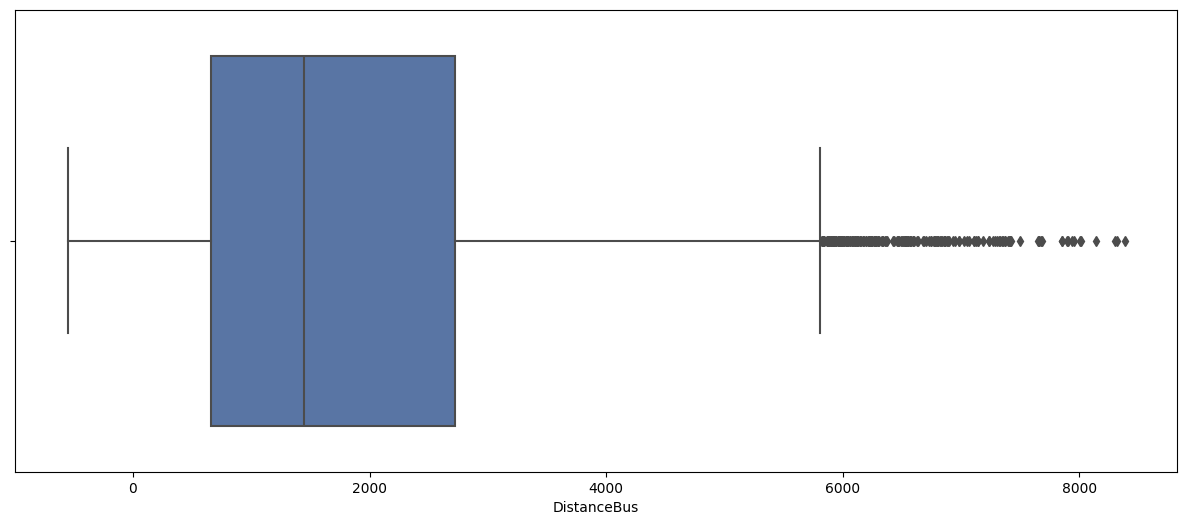

In [68]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df.iloc[:10000][var_name]);

In [69]:
var_name = 'estimateArrive'

In [70]:
# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(df[var_name].describe())


Estadísticas descriptivas:
count     76386.000000
mean        547.547849
std        5128.558343
min           0.000000
25%         213.000000
50%         450.000000
75%         766.000000
max      999999.000000
Name: estimateArrive, dtype: float64


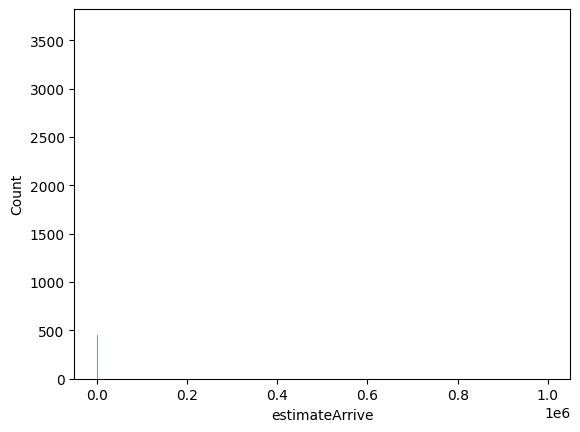

In [71]:
sns.histplot(df[var_name]);

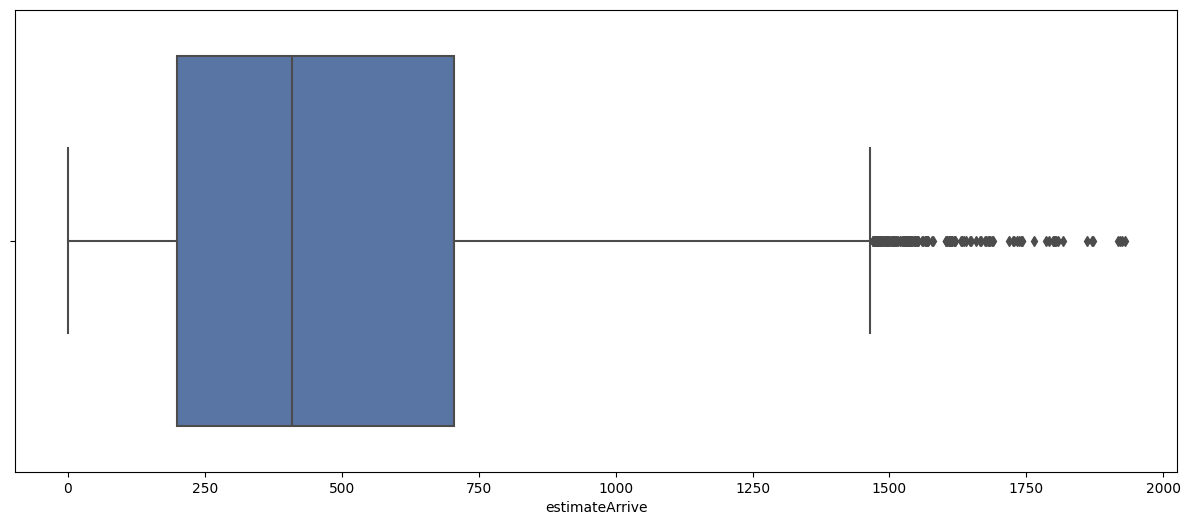

In [72]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df.iloc[:10000][var_name]);

## PROFILING 📑

In [73]:
profile = ProfileReport(
    df, 
    title="🚌 EMT QA", 
    dataset={
        'description': 'EMT - Estimaciones del tiempo de llegada del Bus',
        'url': 'https://apidocs.emtmadrid.es/#api-Block_3_TRANSPORT_BUSEMTMAD-arrives'
    },
    variables={
        "descriptions": {
            "PK": "Identificador único (Primary Key) del dataset, compuesto por <datetime>_B<bus>_L<linea>_S<parada>",
            "date": "Fecha de la petición a la API",
            "datetime": "Fecha y hora de la petición a la API",
            "line": "Línea de bus",
            "stop": "Parada de bus",
            "bus": "Número identificador del bus",
            "positionBusLon": "Longitud de las coordenadas del bus",
            "positionBusLat": "Latitud de las coordenadas del bus",
            "DistanceBus": "Distancia del bus a la parada (en metros)",
            "destination": "Destino del itinerario",
            "deviation": "Desviación en el cálculo del ETA",
            "StartTime": "Hora de inicio de la línea",
            "StopTime": "Hora de fin de la línea",
            "MinimunFrequency": "Frecuencia mínima de la línea",
            "MaximumFrequency": "Frecuencia máxima de la línea",
            "isHead": "Variable booleana para indicar si la parada es la cabecera de la línea",
            "dayType":" Tipo de día (LA: laboral, FE: festivo, SA: sábado)",
            "strike": "Variable para indicar si ese día hay huelga (S) o no (N)",
            "estimateArrive": "Tiempo estimado de espera del bus (en segundos)"
        }
    },
    explorative=True, 
    dark_mode=True
)
profile.to_file(os.path.join(ROOT_PATH, 'notebooks', 'qa_reports', 'emt_report.html'))

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## QA checks ✅

In [74]:
#  Create dataset primary key
df.insert(0, 'PK', '')
df['PK'] = df['datetime'].astype(str) + '_B' + df['bus'].astype(str) + '_L' + df['line'].astype(str) + '_S' + df['stop'].astype(str)
df

,PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
0,2024-03-12 07:58:57.264347_B517_L27_S54,2024-03-12,2024-03-12 07:58:57.264347,517,27,54,-3.690321,40.424226,1617,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,394
1,2024-03-12 07:58:57.264347_B537_L27_S54,2024-03-12,2024-03-12 07:58:57.264347,537,27,54,-3.689487,40.437052,564,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,124
12,2024-03-12 07:58:57.370357_B2469_L134_S1022,2024-03-12,2024-03-12 07:58:57.370357,2469,134,1022,-3.708424,40.498820,1914,MONTECARMELO,0,06:25,23:45,9.0,26.0,False,LA,N,461
13,2024-03-12 07:58:57.370357_B2472_L134_S1022,2024-03-12,2024-03-12 07:58:57.370357,2472,134,1022,-3.704560,40.481786,5905,MONTECARMELO,0,06:25,23:45,9.0,26.0,False,LA,N,1229
14,2024-03-12 07:58:57.370357_B2502_L178_S1022,2024-03-12,2024-03-12 07:58:57.370357,2502,178,1022,-3.700528,40.496409,3142,MONTECARMELO,0,06:00,23:45,6.0,22.0,False,LA,N,763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144864,2024-03-12 09:56:36.139745_B4736_L49_S5329,2024-03-12,2024-03-12 09:56:36.139745,4736,49,5329,-3.711952,40.471423,1673,PITIS,0,06:10,23:45,4.0,15.0,False,LA,N,548
144865,2024-03-12 09:56:36.140625_B9125_L177_S5802,2024-03-12,2024-03-12 09:56:36.140625,9125,177,5802,-3.695560,40.470752,2387,MARQUES DE VIANA,0,06:20,23:30,9.0,24.0,False,LA,N,1600
144866,2024-03-12 09:56:36.140625_B9130_L177_S5802,2024-03-12,2024-03-12 09:56:36.140625,9130,177,5802,-3.688212,40.467565,1365,MARQUES DE VIANA,0,06:20,23:30,9.0,24.0,False,LA,N,700
144873,2024-03-12 09:56:36.142168_B5566_L67_S1615,2024-03-12,2024-03-12 09:56:36.142168,5566,67,1615,-3.700158,40.484840,1096,BARRIO PEÑAGRANDE,0,06:00,23:45,9.0,30.0,False,LA,N,248


In [75]:
print("PK/Unique identifier check")
if df['PK'].nunique() == df.shape[0]:
    print("✅ PK is unique")
else:
    print("❌ PK is not unique")
    display(df[df['PK'].duplicated()][['datetime', 'bus', 'line', 'stop', 'PK']])

PK/Unique identifier check
✅ PK is unique


In [76]:
# As we passed the PK quality check, we can set this PK as dataframe index
df.set_index('PK', inplace=True)

In [77]:
print("Accuray Checks for stop")
stops = ['29', '30', '33', '35', '37', '39', '42', '44', '47', '50', '52', '54', '56', '60', '62', '65', '66', '72', '78', '82', '85', '86', '87', '88', '89', '126', '128', '130', '132', '134', '136', '138', '140', '145', '146', '203', '205', '207', '208', '210', '212', '214', '215', '218', '220', '222', '224', '226', '228', '230', '232', '234', '236', '240', '242', '244', '246', '250', '253', '269', '271', '399', '402', '497', '499', '501', '503', '509', '510', '1021', '1022', '1025', '1357', '1360', '1364', '1366', '1368', '1374', '1376', '1377', '1487', '1488', '1489', '1494', '1496', '1498', '1500', '1501', '1503', '1505', '1507', '1509', '1511', '1515', '1517', '1530', '1532', '1537', '1542', '1544', '1546', '1548', '1550', '1552', '1554', '1556', '1558', '1602', '1604', '1606', '1608', '1610', '1612', '1615', '1617', '1619', '1621', '1623', '1625', '1627', '1629', '1631', '1633', '1732', '1734', '1736', '1739', '1741', '1743', '1745', '1749', '1751', '1753', '1760', '1762', '1837', '1839', '1841', '1843', '1845', '1846', '1848', '1850', '1851', '1852', '1866', '2148', '2150', '2653', '2864', '2968', '2970', '3245', '3247', '3249', '3252', '3253', '3254', '3256', '3258', '3260', '3261', '3267', '3269', '3270', '3272', '3279', '3544', '3566', '3568', '3578', '3580', '3594', '3603', '3605', '3620', '3621', '3623', '3634', '3664', '3670', '3671', '3683', '3733', '3769', '3771', '3778', '3790', '3794', '3796', '3821', '3822', '3823', '3826', '3869', '3870', '3872', '3874', '3918', '4033', '4230', '4264', '4266', '4268', '4273', '4354', '4366', '4382', '4493', '4495', '4501', '4502', '4508', '4651', '4708', '4731', '4732', '4734', '4736', '4741', '4752', '4777', '4968', '5016', '5018', '5020', '5133', '5267', '5329', '5333', '5337', '5395', '5397', '5399', '5443', '5458', '5511', '5517', '5518', '5602', '5603', '5604', '5605', '5606', '5607', '5608', '5609', '5610', '5611', '5612', '5632', '5633', '5634', '5635', '5636', '5722', '5747', '5798', '5799', '5800', '5801', '5802', '5803', '5804', '5805', '5806', '5807', '5887', '5892', '5894', '5899', '5911', '5915', '5917', '5919', '5921', '5926', '5927', '5982', '5984', '5996', '51022', '51023']
stops = [eval(stop) for stop in stops]
print(" Expected stops are : ", stops)
if sum(~df['stop'].isin(stops)) == 0:
    print("✅  - No stops apart from Plaza Castilla stops")
else:
    print("❌  - Below records does belong to expected stops")
    display(df[~df['stop'].isin(stops)][['stop']])

Accuray Checks for stop
 Expected stops are :  [29, 30, 33, 35, 37, 39, 42, 44, 47, 50, 52, 54, 56, 60, 62, 65, 66, 72, 78, 82, 85, 86, 87, 88, 89, 126, 128, 130, 132, 134, 136, 138, 140, 145, 146, 203, 205, 207, 208, 210, 212, 214, 215, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 240, 242, 244, 246, 250, 253, 269, 271, 399, 402, 497, 499, 501, 503, 509, 510, 1021, 1022, 1025, 1357, 1360, 1364, 1366, 1368, 1374, 1376, 1377, 1487, 1488, 1489, 1494, 1496, 1498, 1500, 1501, 1503, 1505, 1507, 1509, 1511, 1515, 1517, 1530, 1532, 1537, 1542, 1544, 1546, 1548, 1550, 1552, 1554, 1556, 1558, 1602, 1604, 1606, 1608, 1610, 1612, 1615, 1617, 1619, 1621, 1623, 1625, 1627, 1629, 1631, 1633, 1732, 1734, 1736, 1739, 1741, 1743, 1745, 1749, 1751, 1753, 1760, 1762, 1837, 1839, 1841, 1843, 1845, 1846, 1848, 1850, 1851, 1852, 1866, 2148, 2150, 2653, 2864, 2968, 2970, 3245, 3247, 3249, 3252, 3253, 3254, 3256, 3258, 3260, 3261, 3267, 3269, 3270, 3272, 3279, 3544, 3566, 3568, 3578, 3580, 3594, 3603, 36

In [78]:
print("Completeness Check for stop")
l1 = df['stop'].unique().tolist()
l1.sort()
l2 = stops
if(l1 == l2):
    print("✅  - Data Set have all stops")
else:
    print("❌  - Data Set does not have all stops")
    print(f"Expected stops are {stops.split('|')}, but we have only stops {df['stop'].unique().tolist()}")

Completeness Check for stop
✅  - Data Set have all stops


### Timestamps

In [79]:
print(f"Min time: {min(df['datetime'])}")
print(f"Max time: {max(df['datetime'])}")

Min time: 2024-03-12 07:58:57.264347
Max time: 2024-03-12 09:56:36.142168


In [80]:
df['datetime'].unique()

<DatetimeArray>
['2024-03-12 07:58:57.264347', '2024-03-12 07:58:57.370357',
 '2024-03-12 07:58:57.376128', '2024-03-12 07:58:57.378086',
 '2024-03-12 07:58:57.379569', '2024-03-12 07:58:57.380708',
 '2024-03-12 07:58:57.380971', '2024-03-12 07:58:57.381120',
 '2024-03-12 07:58:57.381641', '2024-03-12 07:58:57.382561',
 ...
 '2024-03-12 09:56:07.224818', '2024-03-12 09:56:07.291582',
 '2024-03-12 09:56:07.294809', '2024-03-12 09:56:07.300691',
 '2024-03-12 09:56:36.129063', '2024-03-12 09:56:36.138275',
 '2024-03-12 09:56:36.138675', '2024-03-12 09:56:36.139745',
 '2024-03-12 09:56:36.140625', '2024-03-12 09:56:36.142168']
Length: 30668, dtype: datetime64[ns]

### Destinos

In [81]:
df['destination'].unique()

array(['PLAZA CASTILLA', 'MONTECARMELO', 'ALSACIA', 'BARRIO PEÑAGRANDE',
       'PITIS', 'MANOTERAS', 'LAS TABLAS SUR', 'MARQUES DE VIANA',
       'HORTALEZA', 'VALDEBEBAS', 'SANCHINARRO', 'HOSPITAL RAMON Y CAJAL',
       'LAS TABLAS NORTE', 'EMBAJADORES'], dtype=object)

### Buses de cada línea

In [82]:
[f"Buses de la línea {line}: {list(df[df['line'] == line]['bus'].unique())}" for line in lines]

['Buses de la línea 27: [517, 537, 508, 516, 520, 510, 526, 522, 528, 527, 538, 514, 524, 523, 506, 525, 532, 509, 530, 519, 513, 511, 531, 521, 507]',
 'Buses de la línea 42: [5546, 5552, 5548, 5551, 5547, 5553, 5561, 5550]',
 'Buses de la línea 49: [4713, 4736, 4735, 4738, 4732, 4739, 4726, 4727, 4733, 4734, 4824, 4742, 4731, 4859, 4728, 4740, 4860, 4724, 4741, 4737, 4730]',
 'Buses de la línea 67: [5532, 5565, 5562, 5566, 5564, 5568, 5537, 5567, 5563]',
 'Buses de la línea 70: [518, 580, 542, 576, 583, 585, 540, 543, 577, 582, 589, 586, 544, 578, 588, 581, 545, 579, 584, 587, 541]',
 'Buses de la línea 107: [2135, 2145, 2132, 2143, 2146]',
 'Buses de la línea 129: [2138, 2140, 2136, 2137, 2131]',
 'Buses de la línea 134: [2469, 2472, 2465, 2517, 2470, 2471, 2474, 2466, 2473, 2464]',
 'Buses de la línea 135: [2290, 2340, 2338, 2339]',
 'Buses de la línea 173: [2496, 2537, 2495, 2521, 2497, 2553, 2489, 2538]',
 'Buses de la línea 174: [2161, 2264, 2063, 2064, 2314, 2258, 2065, 2071, 2

### Paradas de cada línea

In [83]:
[f"Paradas de la línea {line}: {list(df[df['line'] == line]['stop'].unique())}" for line in lines]

['Paradas de la línea 27: [54, 47, 29, 66, 87, 52, 37, 5511, 86, 65, 33, 85, 62, 39, 35, 72, 50, 60, 44, 89, 78, 82, 88, 42, 56, 5333, 5602, 5443]',
 'Paradas de la línea 42: [1500, 1503, 1505, 1494, 1515, 3568, 5016, 5018, 5611, 1507, 1517, 1501, 1498, 3580, 1509, 1496, 1511, 3733, 3578, 3821, 5020, 5996]',
 'Paradas de la línea 49: [1368, 1366, 1503, 1505, 1357, 1537, 1530, 1532, 1556, 1550, 3822, 4354, 4732, 5329, 5611, 5632, 1542, 1364, 1548, 1544, 4264, 4273, 1546, 1552, 1554, 1558, 4736, 4777, 5634, 3823, 4731, 4734, 5633, 5635, 5636, 5982]',
 'Paradas de la línea 67: [1360, 1374, 1377, 1376, 1604, 1617, 1619, 1550, 1608, 1631, 4741, 5267, 1487, 1489, 1633, 1623, 1625, 1627, 1615, 3826, 1602, 1606, 1610, 1612, 1621, 1629, 5605]',
 'Paradas de la línea 70: [250, 232, 244, 253, 234, 226, 208, 5603, 246, 236, 30, 242, 205, 203, 228, 222, 220, 218, 207, 224, 230, 210, 215, 212, 5458, 4230, 4708, 5747, 240]',
 'Paradas de la línea 107: [208, 214, 1846, 1850, 1851, 5722, 30, 205, 203, 

### Estudio de paradas específicas

In [84]:
stop = 29
stop_df = df[df['stop'] == stop]
stop_df

,date,datetime,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
PK,,,,,,,,,,,,,,,,,,
2024-03-12 07:58:57.382561_B516_L27_S29,2024-03-12,2024-03-12 07:58:57.382561,516,27,29,-3.689767,40.458272,921,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,200
2024-03-12 07:58:57.382561_B520_L27_S29,2024-03-12,2024-03-12 07:58:57.382561,520,27,29,-3.690330,40.452390,1603,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,393
2024-03-12 08:00:57.622811_B516_L27_S29,2024-03-12,2024-03-12 08:00:57.622811,516,27,29,-3.689604,40.459854,661,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,99
2024-03-12 08:00:57.622811_B520_L27_S29,2024-03-12,2024-03-12 08:00:57.622811,520,27,29,-3.690120,40.454557,1179,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,246
2024-03-12 08:01:03.243254_B516_L27_S29,2024-03-12,2024-03-12 08:01:03.243254,516,27,29,-3.689767,40.458272,459,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-12 09:54:03.322745_B526_L27_S29,2024-03-12,2024-03-12 09:54:03.322745,526,27,29,-3.689217,40.463942,9,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,5
2024-03-12 09:55:32.249519_B510_L27_S29,2024-03-12,2024-03-12 09:55:32.249519,510,27,29,-3.689376,40.462346,7,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,6
2024-03-12 09:55:32.249519_B527_L27_S29,2024-03-12,2024-03-12 09:55:32.249519,527,27,29,-3.689484,40.461629,238,PLAZA CASTILLA,0,05:55,23:30,3.0,12.0,False,LA,N,63


In [85]:
stop_df['line'].unique()

['27']
Categories (15, object): ['107', '129', '134', '135', ..., '42', '49', '67', '70']

In [86]:
stop_df['bus'].unique()

[516, 520, 508, 537, 517, ..., 531, 521, 532, 525, 527]
Length: 25
Categories (162, int64): [506, 507, 508, 509, ..., 9120, 9125, 9129, 9130]

## EDA 📊🔍

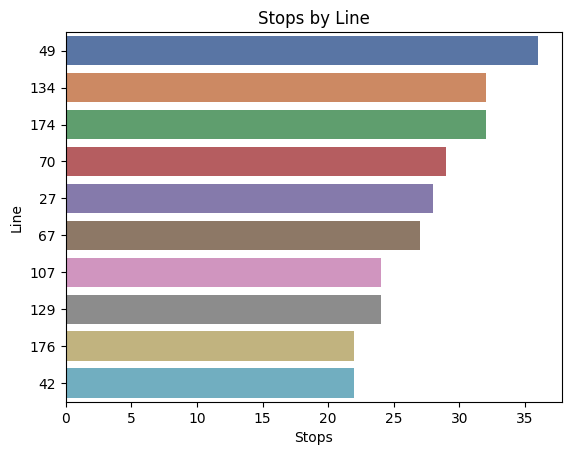

In [88]:
# stops by line
stop_gr = df.groupby('line')["stop"].nunique().reset_index()
top_10_stop = stop_gr.sort_values(by="stop", ascending=False).head(10)

sns.barplot(data=top_10_stop, x='stop', y='line', orient='h', order=top_10_stop['line'])
plt.xlabel('Stops')
plt.ylabel('Line')
plt.title('Stops by Line')
plt.show()

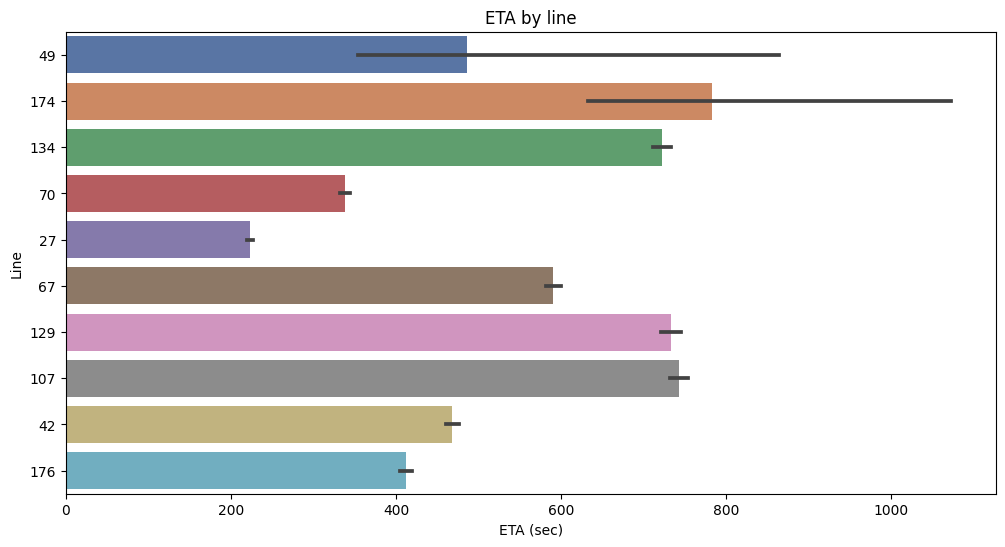

In [89]:
# estimateArrive and line

line_estimate_arrive_sorted = df.sort_values(by='estimateArrive', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='estimateArrive', y='line', data=line_estimate_arrive_sorted, orient='h', order=line_estimate_arrive_sorted['line'].value_counts().head(10).index)
plt.xlabel('ETA (sec)')
plt.ylabel('Line')
plt.title('ETA by line')
plt.show()

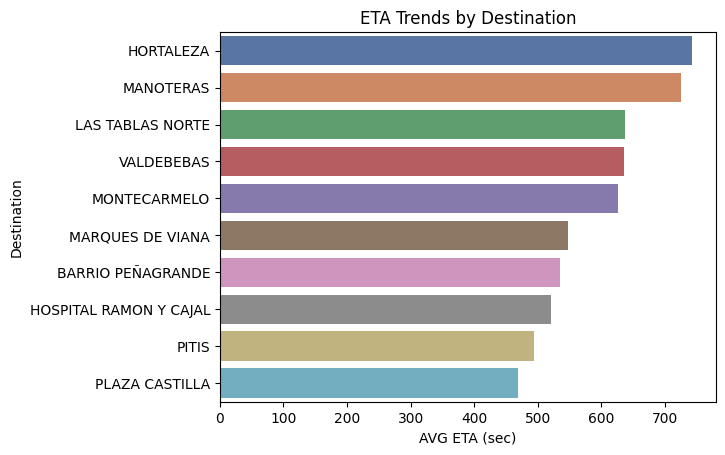

In [90]:
# ETA trends by destination
destination = df.groupby('destination')["estimateArrive"].mean().reset_index()
top_10_dest = destination.sort_values(by="estimateArrive", ascending=False).head(10)

sns.barplot(data=top_10_dest, x='estimateArrive', y='destination', orient='h')
plt.xlabel('AVG ETA (sec)')
plt.ylabel('Destination')
plt.title('ETA Trends by Destination')
plt.show()